In [31]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
import csv 
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FuncFormatter
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [32]:
df = pd.read_csv("Data_DAP.csv")
print("Original Data:")
print(df.head())

Original Data:
                                              title         price  timeStamp  \
0  XM MINH HUY- Hỗ Trợ Trả Góp Xe Đã Qua Sử Dụng  68.686.868 đ        NaN   
1      XE MÁY TÚ TÀI- CHUYÊN CÁC DÒNG HONDA CAO CẤP  68.686.868 đ        NaN   
2             Sh CBS 150cc 2018 biển số TP.Nam Định  62.999.999 đ        NaN   
3                      Xe LEAD nguyên bản, như hình   6.800.000 đ        NaN   
4       Honda Air Blade 125. Bản Sporrt. Chính chủ.  15.600.000 đ        NaN   

    hang       dong  namdangki   soKM   tinhTrang  loaiXe      dungTich  \
0  Honda         SH       2022   8000  Đã sử dụng  Tay ga           NaN   
1  Honda         SH       2022   1000  Đã sử dụng  Tay ga  100 - 175 cc   
2  Honda         SH       2018   8900  Đã sử dụng  Tay ga  100 - 175 cc   
3  Honda       Lead       2012  16800  Đã sử dụng  Tay ga  100 - 175 cc   
4  Honda  Air Blade       2016  18600  Đã sử dụng  Tay ga  100 - 175 cc   

   xuatXu    chinhSachBH TrongLuong  
0     NaN  Bảo 

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3358 entries, 0 to 3357
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        3358 non-null   object 
 1   price        3358 non-null   object 
 2   timeStamp    0 non-null      float64
 3   hang         3358 non-null   object 
 4   dong         3358 non-null   object 
 5   namdangki    3358 non-null   int64  
 6   soKM         3358 non-null   int64  
 7   tinhTrang    3358 non-null   object 
 8   loaiXe       3358 non-null   object 
 9   dungTich     2944 non-null   object 
 10  xuatXu       0 non-null      float64
 11  chinhSachBH  3358 non-null   object 
 12  TrongLuong   3358 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 341.2+ KB


In [34]:
print('Rows     :',df.shape[0])
print('Columns  :',df.shape[1])
print('\nFeatures :\n     :',df.columns.tolist())
print('\nMissing values    :',df.isnull().values.sum())
print('\nUnique values :  \n',df.nunique())

Rows     : 3358
Columns  : 13

Features :
     : ['title', 'price', 'timeStamp', 'hang', 'dong', 'namdangki', 'soKM', 'tinhTrang', 'loaiXe', 'dungTich', 'xuatXu', 'chinhSachBH', 'TrongLuong']

Missing values    : 7130

Unique values :  
 title          2938
price           449
timeStamp         0
hang             25
dong            125
namdangki        38
soKM            432
tinhTrang         1
loaiXe            3
dungTich          5
xuatXu            0
chinhSachBH       1
TrongLuong        1
dtype: int64


1. Data Processing

In [35]:
df['price'] = df['price'].str.replace('.', '').str.replace('đ', '')
df.drop(columns=['timeStamp'], inplace=True)
df.drop(columns=['xuatXu'], inplace=True)
df.drop(columns=['title'], inplace=True)
df.drop(columns=['TrongLuong'], inplace=True)

2. Mising Values

In [36]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum())*100)/df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], 
                         sort=False).sort_values('Total', ascending=False) 
missing_data.head(40)

,Total,Percent
dungTich,414,12.328767
price,0,0.000000
hang,0,0.000000
dong,0,0.000000
namdangki,0,0.000000
soKM,0,0.000000
tinhTrang,0,0.000000
loaiXe,0,0.000000
chinhSachBH,0,0.000000


In [37]:
df['dungTich'].fillna('?', inplace=True)


filtered_data = df[df['dungTich'].str.count('\?') > 0]['dong']

# In ra các dòng duy nhất trong cột 'dong'
unique_dongs_with_question_mark = filtered_data.unique()

# In ra tên các dòng unique trong cột 'dong' có kí tự '?' ở cột 'dungTich' tương ứng
for dong in unique_dongs_with_question_mark:
    print("Row:", dong, "- have missing value:", 
          filtered_data[filtered_data == dong].count())

Row: SH - have missing value: 10
Row: Vision - have missing value: 46
Row: Exciter - have missing value: 68
Row: Winner X - have missing value: 33
Row: Wave - have missing value: 58
Row: Winner - have missing value: 19
Row: Lead - have missing value: 15
Row: Liberty - have missing value: 14
Row: Air Blade - have missing value: 49
Row: Nouvo - have missing value: 11
Row: Vespa - have missing value: 54
Row: Dream - have missing value: 15
Row: R - have missing value: 12
Row: Dòng khác - have missing value: 9
Row: Blade - have missing value: 1


2.1. Handeling Missing Value

In [38]:
dong_list = ['SH', 'Vision', 'Exciter', 'Winner X', 'Wave', 'Winner', 'Lead', 'Liberty', 
             'Air Blade', 'Nouvo', 'Vespa', 'Dream', 'R', 'Dòng khác', 'Blade']

# Lặp qua từng dòng và in ra các giá trị tần suất của cột 'dungTich'
for dong in dong_list:
    # Lọc dữ liệu cho dòng hiện tại
    a = df[df['dong'] == dong]
    
    # In ra thông tin số lượng giá trị trong cột 'dungTich'
    print("Row:", dong, "- have missing value:", 
          filtered_data[filtered_data == dong].count())
    print(a['dungTich'].value_counts())
    print()

Row: SH - have missing value: 10
100 - 175 cc    258
?                10
Trên 175 cc       3
50 - 100 cc       2
Name: dungTich, dtype: int64

Row: Vision - have missing value: 46
100 - 175 cc    196
?                46
50 - 100 cc       3
Trên 175 cc       1
Name: dungTich, dtype: int64

Row: Exciter - have missing value: 68
100 - 175 cc    157
?                68
Name: dungTich, dtype: int64

Row: Winner X - have missing value: 33
100 - 175 cc    47
?               33
50 - 100 cc      1
Trên 175 cc      1
Name: dungTich, dtype: int64

Row: Wave - have missing value: 58
100 - 175 cc     265
?                 58
50 - 100 cc       27
Dưới 50 cc         2
Không biết rõ      1
Name: dungTich, dtype: int64

Row: Winner - have missing value: 19
100 - 175 cc    35
?               19
Trên 175 cc      1
Name: dungTich, dtype: int64

Row: Lead - have missing value: 15
100 - 175 cc    151
?                15
50 - 100 cc       1
Name: dungTich, dtype: int64

Row: Liberty - have missing value: 14


In [39]:
df['price'] = df['price'].astype(float)
df['price'] = df['price'].astype(int)
df = df[(df['dungTich'] != 'Không biết rõ') & (df['dong'] != 'Dòng khác')]

In [40]:
for dong in dong_list:
    # Lọc dữ liệu cho dòng hiện tại
    a = df[df['dong'] == dong]
    
    # Tìm giá trị cao nhất trong cột 'dungTich'
    max_value = df['dungTich'].mode().values[0]
    
    # Thay thế giá trị '?' trong cột 'dungTich' bằng giá trị cao nhất
    df.loc[(df['dong'] == dong) & (df['dungTich'] == '?'), 'dungTich'] = max_value
print(df.head(5
))

      price   hang       dong  namdangki   soKM   tinhTrang  loaiXe  \
0  68686868  Honda         SH       2022   8000  Đã sử dụng  Tay ga   
1  68686868  Honda         SH       2022   1000  Đã sử dụng  Tay ga   
2  62999999  Honda         SH       2018   8900  Đã sử dụng  Tay ga   
3   6800000  Honda       Lead       2012  16800  Đã sử dụng  Tay ga   
4  15600000  Honda  Air Blade       2016  18600  Đã sử dụng  Tay ga   

       dungTich    chinhSachBH  
0  100 - 175 cc  Bảo hành hãng  
1  100 - 175 cc  Bảo hành hãng  
2  100 - 175 cc  Bảo hành hãng  
3  100 - 175 cc  Bảo hành hãng  
4  100 - 175 cc  Bảo hành hãng  


3. Visualize Data

In [41]:
print('Rows     :',df.shape[0])
print('Columns  :',df.shape[1])
print('\nFeatures :\n     :',df.columns.tolist())
print('\nMissing values    :',df.isnull().values.sum())
print('\nUnique values :  \n',df.nunique())


Rows     : 3272
Columns  : 9

Features :
     : ['price', 'hang', 'dong', 'namdangki', 'soKM', 'tinhTrang', 'loaiXe', 'dungTich', 'chinhSachBH']

Missing values    : 0

Unique values :  
 price          440
hang            23
dong           124
namdangki       38
soKM           422
tinhTrang        1
loaiXe           3
dungTich         4
chinhSachBH      1
dtype: int64


In [ ]:

data = df

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,3272.0,2.349749e+07,4.876352e+07,-2.147484e+09,9000000.0,16500000.0,26800000.0,455000000.0
namdangki,3272.0,2.017329e+03,5.185124e+00,1.981000e+03,2015.0,2018.0,2021.0,2024.0
soKM,3272.0,1.608145e+04,5.650099e+04,1.000000e+00,2000.0,5999.0,12000.0,986422.0


Some important observations from the dataset:

Lowest namdangki is 1981, highest is 2024

Highest soKM is 986,422

Price is 23,919,510 vnd

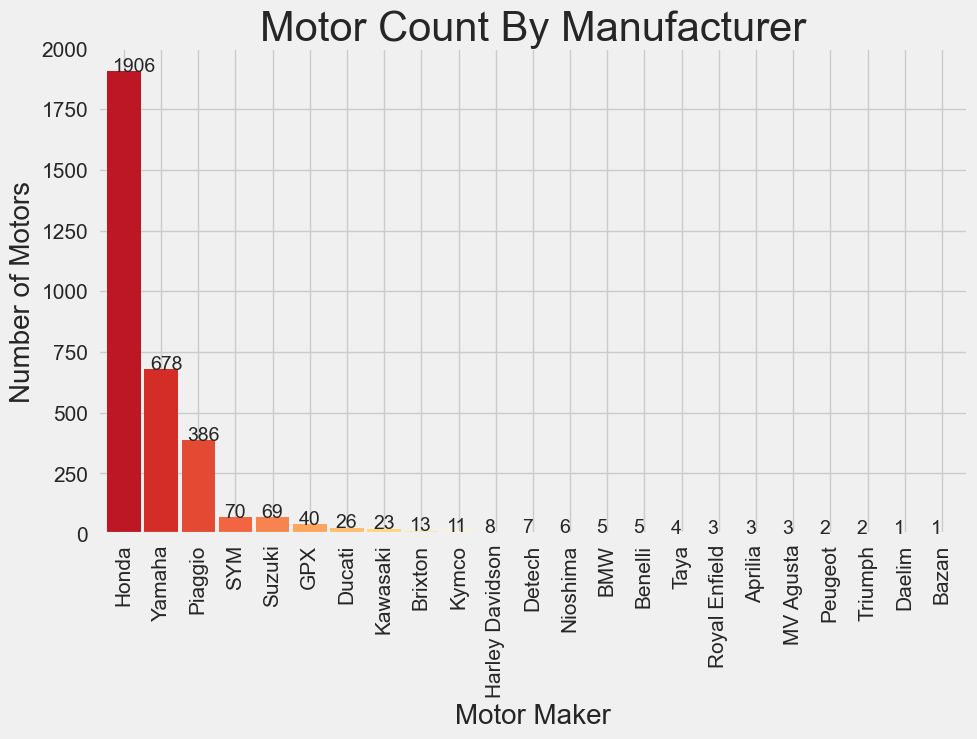

In [44]:
plt.subplots(figsize=(10,6))
ax=df['hang'].value_counts().plot.bar(width=0.9,color=sns.color_palette('RdYlGn',20))
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.xticks(rotation='vertical')
plt.xlabel('Motor Maker',fontsize=20)
plt.ylabel('Number of Motors',fontsize=20)
plt.title('Motor Count By Manufacturer',fontsize=30)
ax.tick_params(labelsize=15)
#plt.yticks(rotation='vertical')
plt.show()
plt.show()

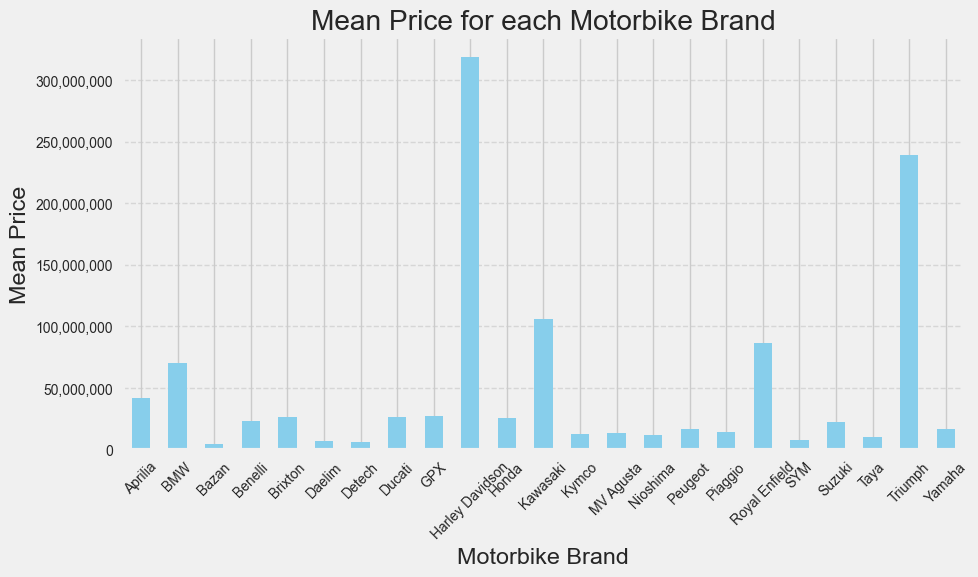

In [45]:
# Tính giá trung bình theo hãng
average_prices = df.groupby('hang')['price'].mean()

# Định dạng giá trị trục y
def y_format(x, pos):
    return '{:,.0f}'.format(x)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', color='skyblue')
plt.title('Mean Price for each Motorbike Brand')
plt.xlabel('Motorbike Brand')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Sử dụng formatter cho trục y
formatter = FuncFormatter(y_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

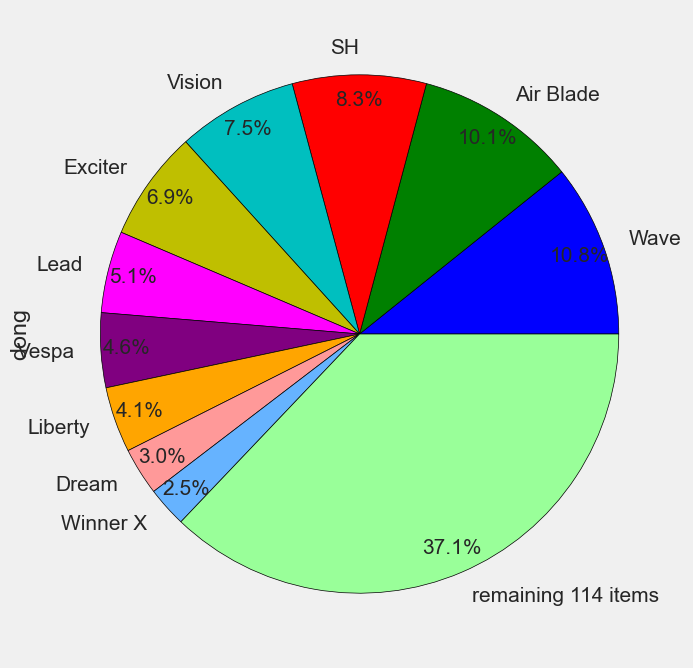

In [46]:
colors = ['b','g','r','c','y','magenta','purple','orange','#ff9999','#66b3ff','#99ff99']
temp = df['dong'].value_counts()
temp2 = temp.head(10)
if len(temp) > 10:
   temp2['remaining {0} items'.format(len(temp)-10)] = sum(temp[10:])
temp2.plot(kind='pie',autopct="%1.1f%%",shadow=False,fontsize=15,pctdistance=0.9,
           colors=colors,wedgeprops={"edgecolor":"0","linewidth":0.5,"linestyle":"solid","antialiased":True},
           figsize=(10,8)) 

pass

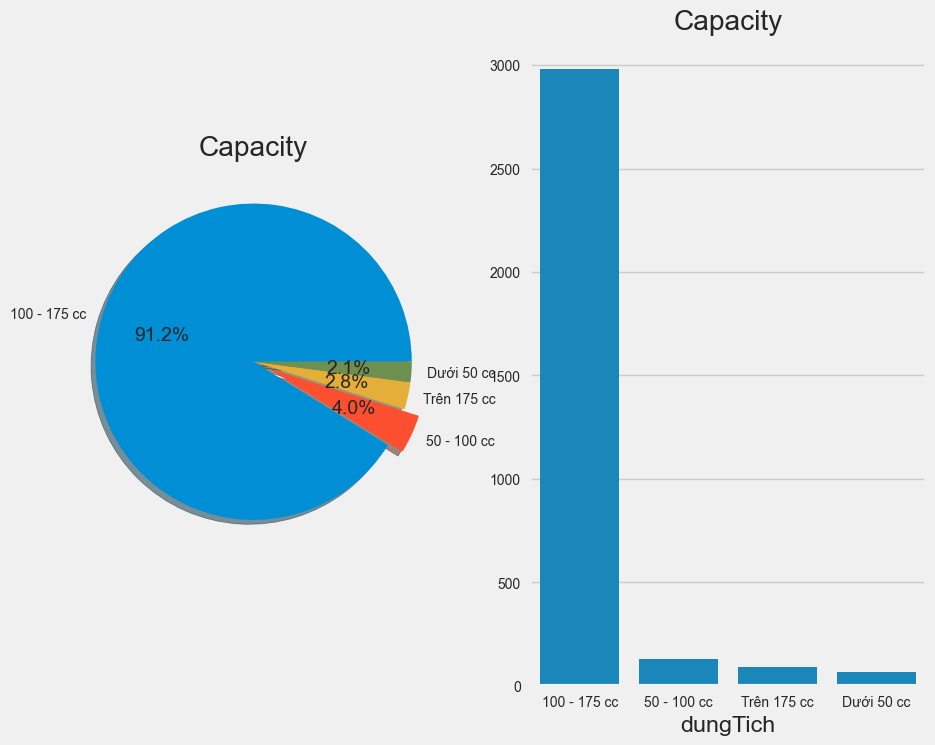

In [47]:
cross_tab = pd.crosstab(df['dong'], df['dungTich'], margins=True)

# Apply background gradient to the transposed crosstab
styled_cross_tab = cross_tab.T.style.background_gradient(cmap='summer_r')

# Plot pie chart and countplot for 'dungTich' column
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

# Plot pie chart
dungTich_counts = df['dungTich'].value_counts()
explode = [0] * len(dungTich_counts)  # Create an explode list of zeros
explode[1] = 0.1  # Set explode for the second wedge to 0.1
dungTich_counts.plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Capacity')
ax[0].set_ylabel('')

# Plot countplot
sns.countplot(x='dungTich', data=df, ax=ax[1], order=dungTich_counts.index)
ax[1].set_title('Capacity')
ax[1].set_ylabel('')
plt.show()

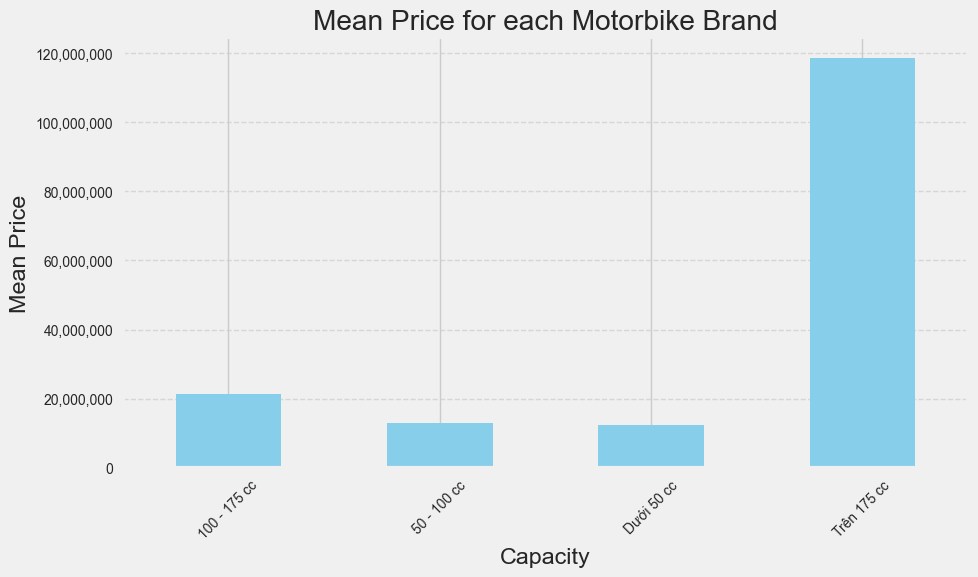

In [48]:
# Tính giá trung bình theo hãng
average_capacity = df.groupby('dungTich')['price'].mean()

# Định dạng giá trị trục y
def y_format(x, pos):
    return '{:,.0f}'.format(x)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
average_capacity.plot(kind='bar', color='skyblue')
plt.title('Mean Price for each Motorbike Brand')
plt.xlabel('Capacity')
plt.ylabel('Mean Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Sử dụng formatter cho trục y
# formatter = FuncFormatter(y_format)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

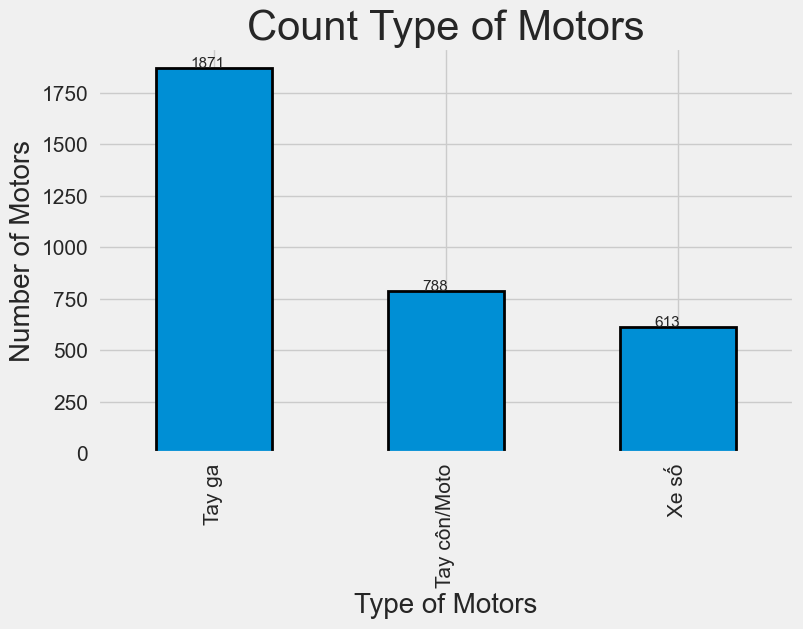

In [49]:
fig = plt.figure(figsize=(8, 5))
cars_type=df.groupby(['loaiXe']).count()['tinhTrang']
ax=cars_type.sort_values(ascending=False).plot.bar(edgecolor='k',linewidth=2)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1),fontsize=11)
plt.xticks(rotation='vertical')
plt.xlabel('Type of Motors',fontsize=20)
plt.ylabel('Number of Motors',fontsize=20)
plt.title('Count Type of Motors',fontsize=30)
ax.tick_params(labelsize=15)
#plt.yticks(rotation='vertical')
plt.show()

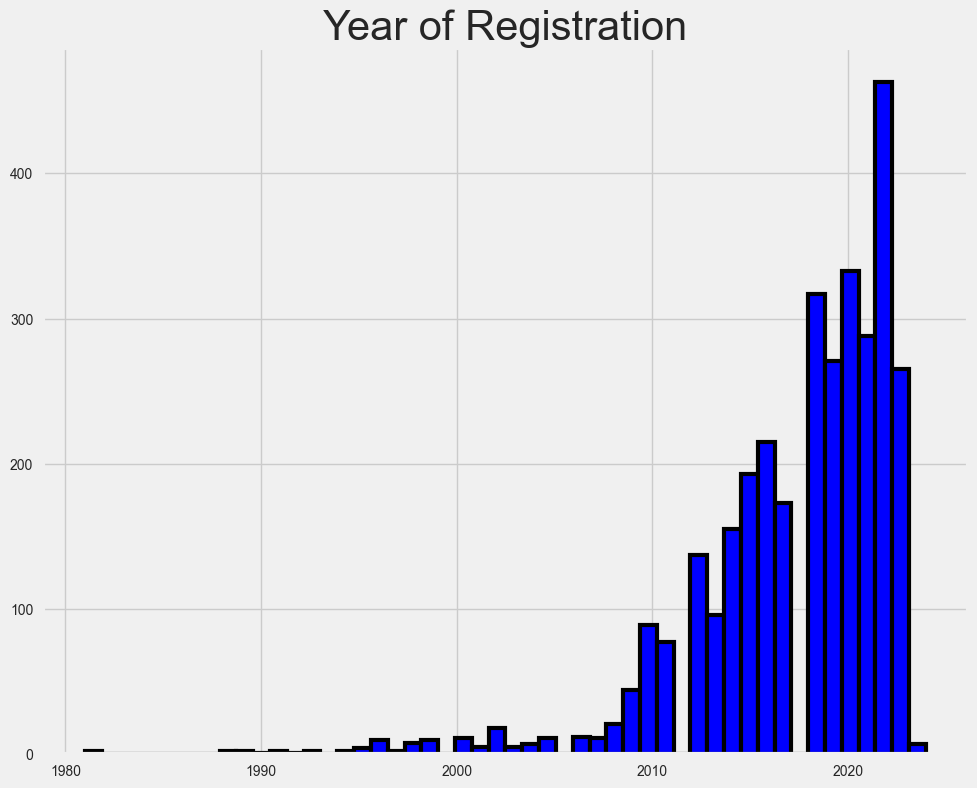

In [50]:
df[['namdangki']].hist(figsize=(10, 8), bins=50, color='b', linewidth=3, edgecolor='k')
plt.tight_layout()
plt.title('Year of Registration',fontsize=30)
plt.show()

4. Histogram

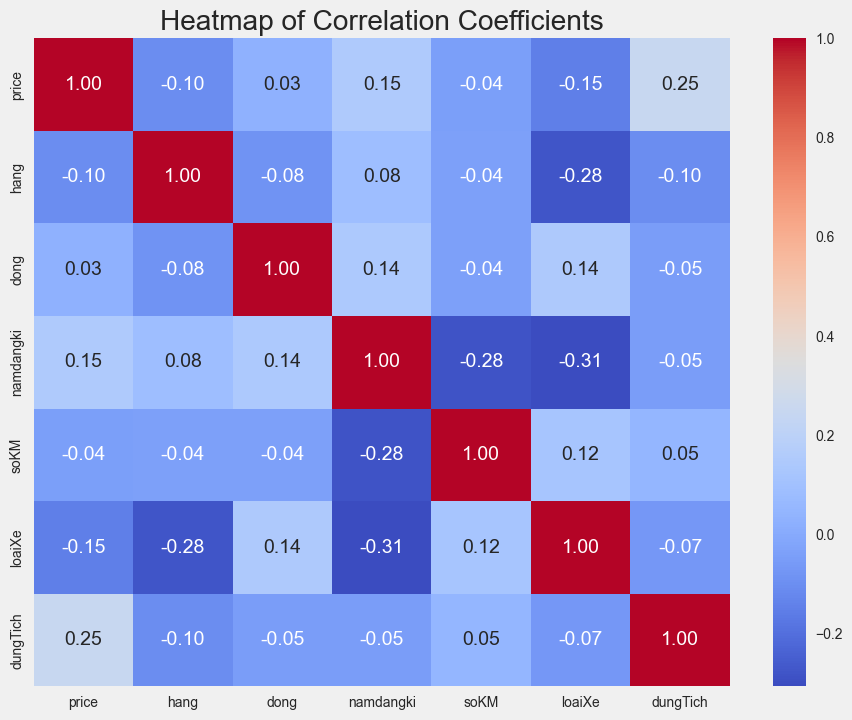

In [51]:

# Convert non-numeric columns to categorical codes
df['hang'] = df['hang'].astype('category').cat.codes
df['dong'] = df['dong'].astype('category').cat.codes
df['loaiXe'] = df['loaiXe'].astype('category').cat.codes
df['dungTich'] = df['dungTich'].astype('category').cat.codes

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Coefficients')
plt.show()
data = df


5. Building Machine Learning Model

In [52]:
from sklearn.model_selection import train_test_split

# split the dataset into training and test set
train, test = train_test_split(data, test_size=0.2, random_state=122)

# check the dimension of the training and test dataset
print('Training dataset: ', train.shape)
print('Test dataset: ', test.shape)

Training dataset:  (2617, 9)
Test dataset:  (655, 9)


In [53]:
# segregate the feature matrix and target vector
Xtrain = train.drop(columns=['price'], axis=1)
ytrain = train['price']

Xtest = test.drop(columns=['price'], axis=1)
ytest = test['price']

In [54]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Xác định danh sách đặc trưng phân loại và đặc trưng số:
# categorical columns
categorical_features = ['hang', 'dong', 'tinhTrang', 'loaiXe', 'dungTich', 'chinhSachBH']

# numeric columns
numeric_features = ['namdangki', 'soKM']

# Tạo các bộ biến đổi (transformers) để tiền xử lý các đặc trưng phân loại và đặc trưng số:
# create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # SimpleImputer với chiến lược ‘most_frequent’ để điền giá trị thiếu bằng giá trị phổ biến nhất.
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoder để chuyển đổi các đặc trưng phân loại thành mã hóa one-hot (binary).
])


# Kết hợp các bộ biến đổi cho các đặc trưng phân loại và đặc trưng số. Điều này cho phép áp dụng các biến đổi khác nhau cho từng loại đặc trưng.
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2))
])

# Tạo một column transformer để áp dụng các biến đổi khác nhau cho các cột khác nhau:
# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])

# create the final pipeline
# pipeline: Kết hợp bước tiền xử lý (preprocessor) với việc tỉ lệ hoá dữ liệu bằng MaxAbsScaler.
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', MaxAbsScaler())])


In [55]:
# perform feature transformation to train and test dataset
Xtrain_processed = pipeline.fit_transform(Xtrain)
Xtest_processed = pipeline.transform(Xtest)
Xtest_processed[1]

<1x149 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [56]:
# transform the 'Price' value into log scale
ytrain_log = np.log(ytrain)
ytest_log = np.log(ytest)


In [57]:
from sklearn.impute import SimpleImputer

# Chuyển đổi ytrain_log thành 2D array
ytrain_log_2d = np.array(ytrain_log).reshape(-1, 1)
# Khởi tạo SimpleImputer với strategy là 'mean' để điền giá trị trung bình
imputer = SimpleImputer(strategy='mean')

# Sử dụng imputer để điền giá trị NaN trong Xtrain_processed
Xtrain_processed_imputed = imputer.fit_transform(Xtrain_processed)
ytrain_log_imputed = imputer.fit_transform(ytrain_log_2d)



Model 1: Decision Tree

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# create a Decision Tree Regressor
tree = DecisionTreeRegressor()

# define the hyperparameter grid to search
param_grid = {
    'max_depth': [10, 20, 30],              # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(estimator = tree, param_grid = param_grid, scoring='neg_mean_squared_error', cv=5)
'''GridSearchCV - công cụ để tinh chỉnh siêu tham số của mô hình máy học. 
Nó cho phép bạn tự động tìm kiếm qua một lưới các giá trị siêu tham số khác nhau 
và chọn ra bộ tham số tối ưu dựa trên một tiêu chí đánh giá như độ chính xác, MSE, hay F1-score.
- scoring : chọn tiêu chí đánh giá
- Cross-validation (cv): số lần lặp lại '''
# fit the model to the training data
grid_search_tree.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_tree.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_tree = grid_search_tree.best_estimator_

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10}


Model 2: Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor

# create a Random Forest Regressor
forest = RandomForestRegressor()

# define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [10, 20, 30],              # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(estimator = forest, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5)

# fit the model to the training data
grid_search_forest.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_forest.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_forest = grid_search_forest.best_estimator_

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [60]:
from joblib import dump

# Lưu mô hình
dump(best_forest, 'best_random_forest_model.joblib')



['best_random_forest_model.joblib']

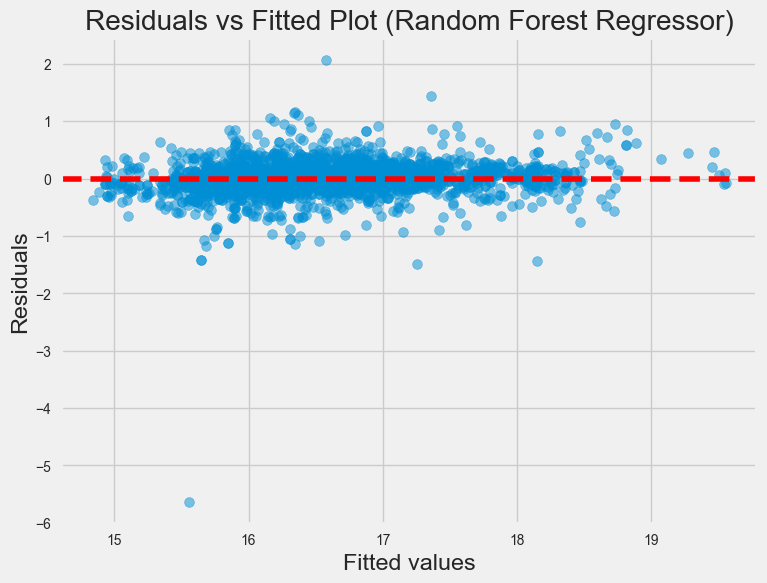

In [61]:

# Dự đoán trên dữ liệu huấn luyện
y_pred_train = grid_search_forest.predict(Xtrain_processed_imputed)

# Tính toán residuals
residuals = ytrain_log - y_pred_train

# Vẽ biểu đồ Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.title('Residuals vs Fitted Plot (Random Forest Regressor)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color='r', linestyle='--')  # Đường thẳng y=0 để tham chiếu
plt.show()


Model 3: KNN Regressor

In [62]:
from sklearn.neighbors import KNeighborsRegressor

# create a KNN Regressor
knn = KNeighborsRegressor(n_neighbors=2)

# define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [2,4,6,8,10]
}

# create the GridSearchCV object
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=5)
#neg_mean_squared_error để đánh giá bằng phương pháp sai số bình phương trung bình âm
# fit the model to the training data
grid_search_knn.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_knn.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_knn = grid_search_knn.best_estimator_

Best Hyperparameters: {'n_neighbors': 6}


Model 4: Redge Regression

In [63]:
from sklearn.linear_model import Ridge

# create Ridge Regression model
ridge = Ridge()

# define the hyperparameter grid for Ridge Regression
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# create the GridSearchCV object for Ridge Regression
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the Ridge model to the training data
ridge_grid_search.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters for Ridge Regression
best_ridge_params = ridge_grid_search.best_params_
print("Best Ridge Hyperparameters:", best_ridge_params)

# get the best Ridge model
best_ridge = ridge_grid_search.best_estimator_

Best Ridge Hyperparameters: {'alpha': 0.1}


Model 5: Lasso Regression

In [64]:
from sklearn.linear_model import Lasso

# create Lasso Regression model
lasso = Lasso()

# define the hyperparameter grid for Lasso Regression
lasso_param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# create the GridSearchCV object for Lasso Regression
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the Lasso model to the training data
lasso_grid_search.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters for Lasso Regression
best_lasso_params = lasso_grid_search.best_params_
print("Best Lasso Hyperparameters:", best_lasso_params)

# get the best Lasso model
best_lasso = lasso_grid_search.best_estimator_

Best Lasso Hyperparameters: {'alpha': 0.1}


6. Model Evaluation

In [65]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def model_eval(X,y,clf,tag):
    ypred = clf.predict(X)
    
    r2 = r2_score(y, ypred)
    mse = mean_squared_error(y, ypred)
    rmse = mean_squared_error(y, ypred, squared=False)
    mae = mean_absolute_error(y, ypred)
    
    metrics = [r2, mse, rmse, mae]
    metricsName = ['R-Square', 'MSE', 'RMSE', 'MAE']
    
    res = pd.DataFrame(metrics, columns=[tag], index=metricsName)
    
    return res

In [66]:
tree_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_tree, 'Decision Tree')
forest_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_forest, 'Random Forest')
knn_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_knn, 'KNearestNeighbors')
ridge_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_ridge, 'Ridge Regression')
lasso_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_lasso, 'LASSO Regression')

# display the performance metrics for all models
models_performance = pd.concat([tree_res,forest_res,knn_res,ridge_res,lasso_res], axis=1)

display(models_performance)

,Decision Tree,Random Forest,KNearestNeighbors,Ridge Regression,LASSO Regression
R-Square,0.885143,0.884490,0.809869,0.694010,0.026294
MSE,0.080195,0.080651,0.132753,0.213647,0.679857
RMSE,0.283187,0.283991,0.364352,0.462220,0.824535
MAE,0.169314,0.184015,0.237716,0.333429,0.637735


In [75]:
import pandas as pd
from tkinter import *
from tkinter import ttk 
import joblib

# # Load the dataset
# df = pd.read_csv(r'C:\Users\huy\HUYYYYYYYY\data_laptop.csv')

# Load the pre-trained model
model = joblib.load('best_random_forest_model.joblib')

class ComboboxWithPlaceholder(ttk.Combobox):
    def __init__(self, master=None, placeholder="PLACEHOLDER", color='grey', values=None, **kwargs):
        super().__init__(master, **kwargs)
        self.placeholder = placeholder
        self.placeholder_color = color
        self.default_fg_color = self['foreground']
        self.values = values if values is not None else []
        self.bind("<FocusIn>", self.foc_in)
        self.bind("<FocusOut>", self.foc_out)
        self.put_placeholder()

    def put_placeholder(self):
        self.set(self.placeholder)
        self['foreground'] = self.placeholder_color

    def foc_in(self, *args):
        if self['foreground'] == self.placeholder_color:
            self.delete(0, 'end')
            self['foreground'] = self.default_fg_color

    def foc_out(self, *args):
        if not self.get() or self.get() == self.placeholder:
            self.put_placeholder()
# Create Tkinter main
main = Tk()
main.title("Used motorbike price prediction")
# Lấy kích thước màn hình
screen_width = main.winfo_screenwidth()
screen_height = main.winfo_screenheight()
# Đặt kích thước và vị trí của cửa sổ
main.geometry(f'800x400+{screen_width//2-150}+{screen_height//2-100}')
# Tiêu đề 
name = Label(main, font = ('Arial', 12), text = 'DANH SÁCH CÁC TÙY CHỌN', bg = 'red', fg = 'white') # tiêu đề
# Đặt nhãn vào  cửa sổ
name.place(x = 100, y = 10)
# dụ đoán giá
price = Label(main, font = ('Arial', 12), text = 'GIÁ DỰ ĐOÁN', bg = 'red', fg = 'white') # tiêu đề
# Đặt nhãn vào  cửa sổ
price.place(x = 500, y = 10)
# Function to predict price
def predict_price():
    # Prepare input data for prediction
    input_data = {
        'hang': hang.get(),
        'dong': dong.get(),
        'namdangki': namdangki.get(),
        'soKM': soKM.get(),
        'tinhTrang': tinhtrang.get(),
        'loaiXe': loaixe.get(),
        'dungTich': dungtich.get(),
        'chinhSachBH': chinhsachBH.get(),
    }
    input_df = pd.DataFrame([input_data])
    test_predict_price = pipeline.transform(input_df)
    # Create a DataFrame with the input data
    try:
        predicted_price = model.predict(test_predict_price)
        predicted_price = np.exp(predicted_price)
        result_label.config(text = f'Predicted Price: {int(predicted_price)}')
    


    except Exception as e:
        result_label.config(text=f'Error: {str(e)}')

# Create and place widgets

# hãng xe
hang_label = ttk.Label(main, text="Hãng")
hang_label.place(x = 50, y = 50)
hang = ttk.Combobox(main,values=['Honda',
                                 'Yamaha', 
                                'Piaggio',
                                'Liberty'])
hang.place(x = 150, y = 50)

# dòng xe
dong_label = ttk.Label(main, text="Dòng")
dong_label.place(x = 50, y = 90)
dong = ttk.Combobox(main,values=['SH', 'Vision', 'Exciter', 'Winner X', 'Wave', 'Winner', 'Lead', 'Liberty', 
             'Air Blade', 'Nouvo', 'Vespa', 'Dream', 'R', 'Dòng khác', 'Blade'])
dong.place(x = 150, y = 90)
def update_dong(event):
    check_hang = hang.get()
    if check_hang == 'Honda':
        dong['values'] = ['SH', 'Vision', 'Winner', 'Lead', 'Air Blade', 'Dream', 'Blade']
    elif check_hang == 'Yamaha':
        dong['values'] = ['Exciter', 'Winner X', 'Nouvo', 'R']
    elif check_hang == 'Piaggio':
        dong['values'] = ['Vespa']
    elif check_hang == 'Liberty':
        dong['values'] = ['Liberty']
    else:
        dong['values'] = []

hang.bind('<<ComboboxSelected>>', update_dong)
# năm đăng kí
namdangki_label = ttk.Label(main, text="Năm đăng kí")
namdangki_label.place(x = 50, y = 140)
namdangki = ttk.Entry(main)
namdangki.place(x = 150, y = 140)

#số km đã đi
soKM_label = ttk.Label(main, text="Số KM đã đi")
soKM_label.place(x = 50, y = 180)
soKM = ttk.Entry(main)
soKM.place(x = 150, y = 180)

#tình trạng
tinhtrang_label = Label(main, text="Tình trạng")
tinhtrang_label.place(x = 50, y = 220)
tinhtrang = ttk.Combobox(main,values=['Đã sử dụng'])
tinhtrang.place(x = 150, y = 220)

#loại xe
loaixe_label = ttk.Label(main, text="Loại xe")
loaixe_label.place(x = 50, y = 260)
loaixe = ttk.Combobox(main,values = ['Tay côn/Moto', 'Tay ga', 'Xe số'])
loaixe.place(x = 150, y = 260)

#dung tích xe
dungtich_label = ttk.Label(main, text="Phân khối")
dungtich_label.place(x = 50, y = 300)
dungtich  = ttk.Combobox(main,values=['50 - 100 cc', '100 - 175 cc', 'Trên 175 cc'])
dungtich.place(x = 150, y = 300)

#chinhSachBH
chinhsachBH_label = Label(main, text="Bảo hành hãng")
chinhsachBH_label.place(x = 50, y = 340)
chinhsachBH = ttk.Combobox(main,values=['Bảo hành hãng', 'Hết bảo hành'])
chinhsachBH.place(x = 150, y = 340)

# Add more widgets for other features...

predict_button = Button(main, text="DỰ ĐOÁN", command = predict_price)
predict_button.place(x = 350, y = 340)

result_label = Label(main, text="Giá", fg="red", font=("Arial", 20))
result_label.place(x = 400, y = 200)


# Run the Tkinter event loop
main.configure(bg='Orange')
main.mainloop()

In [77]:
#  cái này test thư ko cần nhập
input_data = {
    'hang': 'Honda',
    'dong': 'Vision',
    'namdangki':2018,
    'soKM': 3200,
    'tinhTrang': 'Đã sử dụng',
    'loaiXe': 'Tay ga',
    'dungTich': '100 - 175 cc',
    'chinhSachBH': 'Bảo hành hãng',
}
input_df = pd.DataFrame([input_data])
test_predict_price = pipeline.transform(input_df)
# Create a DataFrame with the input data
# Make prediction
predicted_price = model.predict(test_predict_price)
# result_label.config(text = f'Predicted Price: ${predicted_price[0]:,.2f}')
# predicted_price = np.exp(predicted_price)
predicted_price


array([16.12651904])